# Часть 1. Теория

Реализуйте `kernel SVM` с ипользованием пакета `optimize` (как было на практике) с использованием полиномиального ядра. Продемонстрируйте результаты, сравните с библиотечным вариантом, на наборе данных типа концентрических окружностей

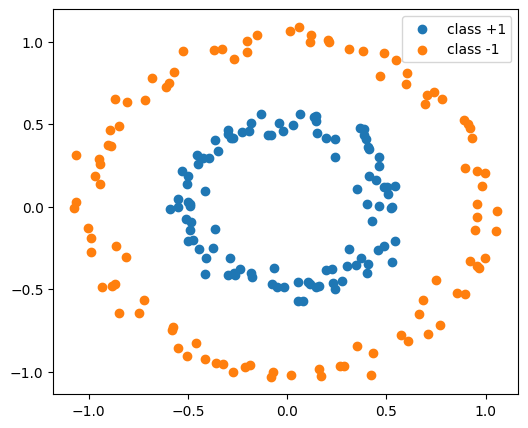

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.svm import SVC

X, y = make_circles(n_samples=200, factor=0.5, noise=0.05, random_state=42)

y = np.where(y == 0, -1, 1)

plt.figure(figsize=(6,5))
plt.scatter(X[y==1][:,0], X[y==1][:,1], label='class +1')
plt.scatter(X[y==-1][:,0], X[y==-1][:,1], label='class -1')
plt.legend()
plt.show()


In [ ]:
def polynomial_kernel(X, Z, degree=2, c=1.0):
    return (X @ Z.T + c)**degree

In [ ]:
def compute_kernel_matrix(X, kernel_func, **kernel_params):
    n = X.shape[0]
    K = kernel_func(X, X, **kernel_params)
    return K

K = compute_kernel_matrix(X, polynomial_kernel, degree=2, c=1.0)

In [ ]:
import numpy as np
from scipy.optimize import minimize

def objective(alpha, y, K):
    n = len(alpha)
    s1 = np.sum(alpha)
    alpha_y = alpha * y
    s2 = np.sum((alpha_y[:,None] * alpha_y[None,:]) * K)

    return -s1 + 0.5*s2

def objective_grad(alpha, y, K):
    alpha_y = alpha * y
    v = alpha_y @ K
    return -np.ones(len(alpha)) + y * v


In [ ]:
def zerofun(alpha, y):
    return np.dot(alpha, y)

C = 1.0
n = X.shape[0]
alpha0 = np.zeros(n)

cons = (
    {'type':'eq', 'fun': lambda a: zerofun(a, y)},
)
bnds = [(0, C) for _ in range(n)]

res = minimize(fun=objective,
               x0=alpha0,
               args=(y, K),
               method='SLSQP',
               jac=objective_grad,
               bounds=bnds,
               constraints=cons)

alpha_opt = res.x


In [ ]:
def compute_b(alpha, y, K, tol=1e-5):
    support_idx = np.where((alpha > tol) & (alpha < C - tol))[0]
    b_vals = []
    for i in support_idx:
        val = (1/y[i]) - np.sum(alpha * y * K[:, i])
        b_vals.append(val)
    return np.mean(b_vals) if len(b_vals) > 0 else 0.0

b_opt = compute_b(alpha_opt, y, K)


In [ ]:
def svm_predict(X_train, y_train, alpha, b, X_test, kernel_func, **kernel_params):
    K_test = kernel_func(X_train, X_test, **kernel_params)
    decision = (alpha * y_train)[:,None] * K_test
    scores = np.sum(decision, axis=0) + b
    return np.sign(scores), scores


In [ ]:
y_pred, scores = svm_predict(X, y, alpha_opt, b_opt, X, polynomial_kernel, degree=2, c=1.0)
acc_train = np.mean(y_pred == y)
print("Accuracy (train, custom SVM) =", acc_train)

clf = SVC(kernel='poly', degree=2, coef0=1.0, C=1.0)
clf.fit(X, y)
acc_train_lib = clf.score(X, y)
print("Accuracy (train, sklearn) =", acc_train_lib)

Accuracy (train, custom SVM) = 1.0
Accuracy (train, sklearn) = 1.0


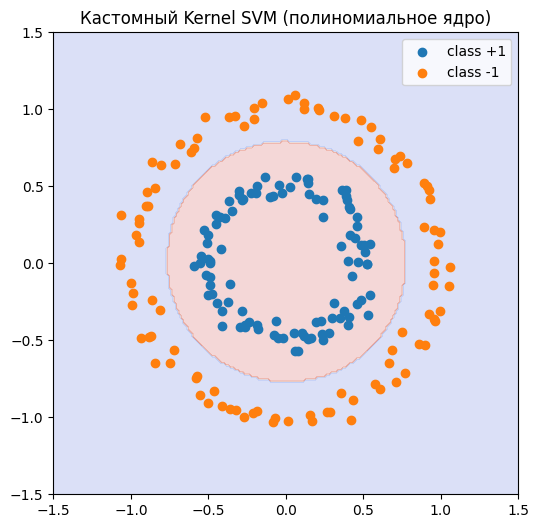

In [ ]:
xx, yy = np.meshgrid(np.linspace(-1.5, 1.5, 200),
                     np.linspace(-1.5, 1.5, 200))
grid = np.c_[xx.ravel(), yy.ravel()]

y_pred_grid, _ = svm_predict(X, y, alpha_opt, b_opt, grid, polynomial_kernel, degree=2, c=1.0)
y_pred_grid = y_pred_grid.reshape(xx.shape)

plt.figure(figsize=(6,6))
plt.contourf(xx, yy, y_pred_grid, alpha=0.2, cmap=plt.cm.coolwarm)
plt.scatter(X[y==1][:,0], X[y==1][:,1], label='class +1')
plt.scatter(X[y==-1][:,0], X[y==-1][:,1], label='class -1')
plt.title("Кастомный Kernel SVM (полиномиальное ядро)")
plt.legend()
plt.show()


# Часть 2. Детектирование аномалий на основе One-Class SVM
Рассмотрим задачу детектирование сетевых атак: Intrusion Detection. Будем использовать данные из KDD Cup 1999 Competition ( http://kdd.ics.uci.edu/databases/kddcup99/task.html). Полная база данных содержит около пяти миллионов записей о сетевых соединениях и различных типах атаках. Mы будем работать подвыборкой в 10% от оригинального датасета, отсутствие атаки обозначено как “normal”, а ее наличие — как “abnormal”.

In [ ]:
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

np.random.seed(0)

In [ ]:
from sklearn.svm import OneClassSVM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from sklearn.model_selection import train_test_split

from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD as TSVD

Считаем данные:

In [ ]:
train = pd.read_csv('train')
test = pd.read_csv('test', delimiter = ';')
X_test = np.array(test.drop(test.columns[[0, 1, 2, 3]], axis=1))
np.save('test_np', X_test)

In [ ]:
train.head(n=10)

,0,tcp,http,SF,181,5450,0.1,0.2,0.3,0.4,...,9.1,1.00.1,0.00.6,0.11,0.00.7,0.00.8,0.00.9,0.00.10,0.00.11,normal.
0,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,59,1.0,0.0,0.02,0.00,0.0,0.0,0.0,0.0,normal.
5,0,tcp,http,SF,212,1940,0,0,0,0,...,69,1.0,0.0,1.00,0.04,0.0,0.0,0.0,0.0,normal.
6,0,tcp,http,SF,159,4087,0,0,0,0,...,79,1.0,0.0,0.09,0.04,0.0,0.0,0.0,0.0,normal.
7,0,tcp,http,SF,210,151,0,0,0,0,...,89,1.0,0.0,0.12,0.04,0.0,0.0,0.0,0.0,normal.
8,0,tcp,http,SF,212,786,0,0,0,1,...,99,1.0,0.0,0.12,0.05,0.0,0.0,0.0,0.0,normal.
9,0,tcp,http,SF,210,624,0,0,0,0,...,109,1.0,0.0,0.06,0.05,0.0,0.0,0.0,0.0,normal.


В выборке метками $\{-1, 1\}$ обозначены аномальныe и нормальные наблюдения. Посмотрим на гистограмму классов:

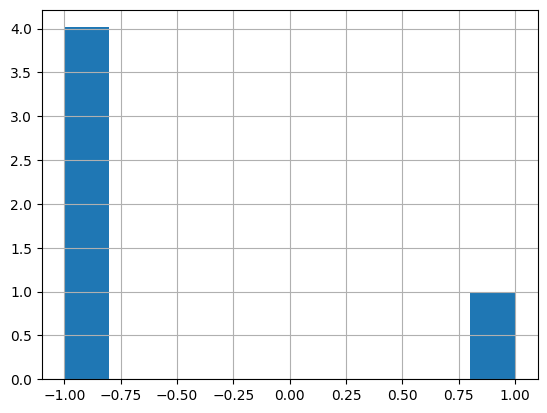

In [ ]:
y_train = (train['normal.'] == 'normal.') * 2 - 1
plt.hist(y_train, density=True);
plt.grid(True)

«Отрежем» не нужные для обучения колонки и целевую переменную.

In [ ]:
X_train = train.drop(train.columns[[0, 1, 2, 3, 41]], axis=1)
y_train = y_train

Посмотрим на признаки. Самый простой способ оценить их качество — это посчитать дисперсию:

In [ ]:
X_train.var()

,0
181,9.765770e+11
5450,1.091644e+09
0.1,4.453072e-05
0.2,1.817249e-02
0.3,3.036300e-05
0.4,6.116857e-01
0.5,2.408584e-04
1,1.262687e-01
0.6,3.233984e+00
0.7,1.113194e-04


In [ ]:
X_train.shape

(494020, 37)

Видим, что есть два константных признака. Их можно удалить:

In [ ]:
idx = np.where(X_train.var() == 0)[0]
cols = X_train.columns[idx]
X_train.drop(cols, axis=1, inplace=True)

Следующее, что можно сделать, это посмотреть попарные корреляции признаков:

<Figure size 500x500 with 0 Axes>

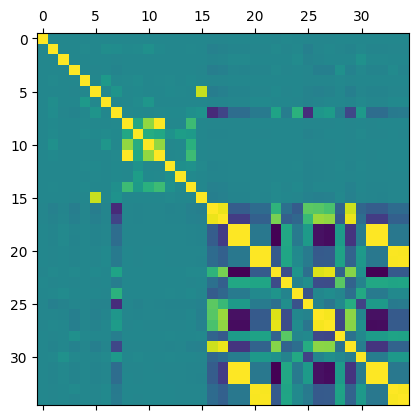

In [ ]:
plt.figure(figsize=(5,5));
plt.matshow(X_train.corr());

Такая структура обещает эффективное снижение размерности. Почему?

Визуально видно, что матрица содержит несколько "блоков" жёлтого цвета вдоль главной диагонали. Это означает, что внутри каждой группы признаки сильно коррелируют друг с другом. Такие признаки, как правило, содержат избыточную информацию, и вместо них можно использовать одну или несколько обобщённых компонент

### Задание 1
Оцените с помощью `randomized SVD` количество компонент достаточных для сжатия и дальнейшего ускорения обучения. (`randomized SVD` - быстрый способ оценки количества компонент)

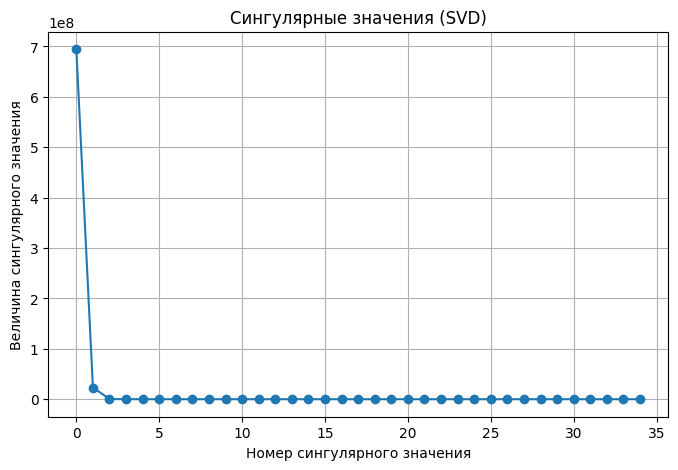

In [ ]:
X_train = np.array(X_train)

look_on_components = 50

U, Sigma, VT = randomized_svd(X_train,
                              n_components=look_on_components,
                              random_state=42)

plt.figure(figsize=(8,5))
plt.plot(Sigma, marker='o')
plt.title("Сингулярные значения (SVD)")
plt.xlabel("Номер сингулярного значения")
plt.ylabel("Величина сингулярного значения")
plt.grid(True)
plt.show()


### Задание 2

Выберите количество компонент для сжатия и примените **truncated SVD**

In [ ]:
from sklearn.decomposition import TruncatedSVD

model = TruncatedSVD(n_components=1, random_state=42)

X_train_proj = model.fit_transform(X_train)
print("Исходная размерность:", X_train.shape)
print("Размерность после сжатия:", X_train_proj.shape)


Исходная размерность: (494020, 35)
Размерность после сжатия: (494020, 1)


### Задание 3

Проведите подбор параметров $\nu$ и $\gamma$ для модели OneClassSVM.

Подбор сразу двух параметров может быть затруднен с вычислительной точки зрения (занимает много времени на слабых ПК). В таком случае возможны два выхода:

1) Проводить раздельный подбор гиперпараматров. Сначала поиск по $\nu$, затем при оптимальном $\nu_{opt}$ провести поиск по $\gamma$

2) Уменьшить размер датасета

Поиск параметров предлагается провести в следующей области параметров:

$\nu$: [0.5,1]

$\gamma$: [0.1, 1]


In [ ]:
subsample_N = X_train_proj.shape[0]

X_subsample = X_train_proj[0:subsample_N]
y_subsample = y_train[0:subsample_N]

print(X_train_proj.shape)
print(X_subsample.shape)

(494020, 1)
(494020, 1)


#### Проведем поиск по первому параметру $\nu$:

In [ ]:
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score

subsample_N = 10000
X_subsample = X_train_proj[:subsample_N]
y_subsample = y_train[:subsample_N]

scores = {
    'accuracy_score': make_scorer(accuracy_score)
}

param_grid_nu = {
    'nu': [0.1, 0.2, 0.3]
}

model_nu = OneClassSVM(kernel='rbf', gamma='scale')

search_nu = GridSearchCV(
    model_nu,
    param_grid_nu,
    scoring=scores,
    n_jobs=-1,
    cv=2,
    refit='accuracy_score'
)

search_nu.fit(X_subsample, y_subsample)

print("Проверенные значения nu:     ", search_nu.cv_results_['param_nu'].data)
print("Соответствующие accuracy: ", search_nu.cv_results_['mean_test_accuracy_score'])

all_scores = search_nu.cv_results_['mean_test_accuracy_score']
all_nus    = search_nu.cv_results_['param_nu'].data

mask_nu_neq_1 = (all_nus != 1.0)
best_idx = np.argmax(all_scores[mask_nu_neq_1])
nu_opt = all_nus[mask_nu_neq_1][best_idx]

print("Оптимальное nu:", nu_opt)


Проверенные значения nu:      [0.1 0.2 0.3]
Соответствующие accuracy:  [0.837 0.784 0.661]
Оптимальное nu: 0.1


In [ ]:
param_grid_gamma = {
    'gamma': [0.001, 0.01, 0.1]
}

model_gamma = OneClassSVM(kernel='rbf', nu=nu_opt)

search_gamma = GridSearchCV(
    model_gamma,
    param_grid_gamma,
    scoring=scores,
    n_jobs=-1,
    cv=2,
    refit='accuracy_score'
)

search_gamma.fit(X_subsample, y_subsample)

print("Проверенные значения gamma:     ", search_gamma.cv_results_['param_gamma'].data)
print("Соответствующие accuracy: ", search_gamma.cv_results_['mean_test_accuracy_score'])

best_idx_gamma = np.argmax(search_gamma.cv_results_['mean_test_accuracy_score'])
gamma_opt = search_gamma.cv_results_['param_gamma'].data[best_idx_gamma]

print("Оптимальное gamma:", gamma_opt)


Проверенные значения gamma:      [0.001 0.01  0.1  ]
Соответствующие accuracy:  [0.671 0.513 0.47 ]
Оптимальное gamma: 0.001


Теперь необходимо подобрать $\gamma$. Оптимальнее конечно было бы подбирать сразу оба параметра, но если это невозможно для ваших ресурсов в силу вычислительной сложности, то проведите отдельный поиск $\gamma$ при найденном ранее $\nu_{opt}$.

# Задание
+ Используя кроссвалидацию, оценить качество определения аномальных наблюдений с помощью обученной модели `One-Class SVM`
+ Исследовать зависимость этого качества от параметров метода (ширина ядра, доля выбросов в модели, задаваемая параметром $\nu$)

In [ ]:
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score

param_grid = {
    'nu': [0.1, 0.2, 0.3],
    'gamma': [0.001, 0.01, 0.1]
}

model = OneClassSVM(kernel='poly')

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'f1': make_scorer(f1_score, pos_label=1)
}

search = GridSearchCV(
    model,
    param_grid,
    scoring=scoring,
    n_jobs=-1,
    cv=2,
    refit='accuracy'
)

search.fit(X_subsample, y_subsample)

print("Лучшие параметры:", search.best_params_)
print("Лучший accuracy:", search.best_score_)

results = search.cv_results_


Лучшие параметры: {'gamma': 0.001, 'nu': 0.1}
Лучший accuracy: 0.907
